In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd
print(pd.__version__)

1.1.5



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_plot, backtest_stats

from pprint import pprint

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [8]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-01-01',
#                      ticker_list = config.DOW_30_TICKER).fetch_data()

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
#                     use_turbulence=False,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# processed['log_volume'] = np.log(processed.volume*processed.close)
# processed['change'] = (processed.close-processed.open)/processed.close
# processed['daily_variance'] = (processed.high-processed.low)/processed.close
# processed.head()

In [11]:
# processed.to_csv("processed.csv")

In [12]:
processed = pd.read_csv("processed.csv")

In [13]:
processed = processed[processed.tic.isin(['AAPL', 'MSFT'])]


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2016-01-01
## Trade data split: 2016-01-01 to 2021-01-01

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2016-01 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [14]:
train = data_split(processed, '2009-01-01','2016-01-01')
trade = data_split(processed, '2016-01-01','2021-01-01')
print(len(train))
print(len(trade))

3524
2518


In [20]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
import gym
import time
from gym.utils import seeding
from gym import spaces
import matplotlib

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger

from finrl.env.accounting.ledger import Ledger


class StockTradingEnvCashpenalty(gym.Env):
    """
    A stock trading environment for OpenAI gym
    This environment penalizes the model for not maintaining a reserve of cash.
    This enables the model to manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) - initial_cash - max(0, sum(cash, asset_value)*cash_penalty_proportion-cash))/(days_elapsed)
        This reward function takes into account a liquidity requirement, as well as long-term accrued rewards.
    Parameters:
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int): max number of share purchases allowed per asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares can be bought in each trade.
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. It could be OHLC columns or any other variables such as technical indicators and turbulence index
        cash_penalty_proportion (int, float): Penalty to apply if the algorithm runs out of cash
        patient (bool): option to choose whether end the cycle when we're running out of cash or just don't buy anything until we got additional cash

    RL Inputs and Outputs
        action space: [<n_assets>,] in range {-1, 1}
        state space: {start_cash, [shares_i for in in assets], [[indicator_j for j in indicators] for i in assets]]}
    TODO:
        Organize functions
        Write README
        Document tests
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        buy_cost_pct=3e-3,
        sell_cost_pct=3e-3,
        long_term_tax_rate = 0.15,
        short_term_tax_rate = 0.35,
        tax_horizon_days = 365,
        date_col_name="date",
        hmax=10,
        discrete_actions=False,
        shares_increment=1,
        turbulence_threshold=None,
        print_verbosity=10,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        cache_indicator_data=True,
        cash_penalty_proportion=0.1,
        random_start=True,
        patient=False,
        currency="$",
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start
        self.discrete_actions = discrete_actions
        self.patient = patient
        self.currency = currency
        self.df = self.df.set_index(date_col_name)
        self.shares_increment = shares_increment
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.long_term_tax_rate = long_term_tax_rate
        self.short_term_tax_rate = short_term_tax_rate
        self.tax_horizon_days = tax_horizon_days
        self.turbulence_threshold = turbulence_threshold
        self.daily_information_cols = daily_information_cols
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.turbulence = 0
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [
                self.get_date_vector(i) for i, _ in enumerate(self.dates)
            ]
            print("data cached!")

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)

    @property
    def current_step(self):
        return self.date_index - self.starting_point

    @property
    def cash_on_hand(self):
        # amount of cash held at current timestep
        return self.state_memory[-1][0]

    @property
    def holdings(self):
        # Quantity of shares held at current timestep
        return self.state_memory[-1][1 : len(self.assets) + 1]

    @property
    def closings(self):
        return np.array(self.get_date_vector(self.date_index, cols=["close"]))

    def reset(self):
        self.seed()
        self.ledger = Ledger(assets = self.assets, tax_threshold_days = self.tax_horizon_days)
        self.sum_trades = 0
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.turbulence = 0
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            "reward": [],
        }
        init_state = np.array(
            [self.initial_amount]
            + [0] * len(self.assets)
            + self.get_date_vector(self.date_index)
        )
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v

    def return_terminal(self, reason="Last Date", reward=0):
        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        # Add outputs to logger interface
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        logger.record("environment/GainLoss_pct", (gl_pct - 1) * 100)
        logger.record(
            "environment/total_assets",
            int(self.account_information["total_assets"][-1]),
        )
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        logger.record("environment/total_reward_pct", (reward_pct - 1) * 100)
        logger.record("environment/total_trades", self.sum_trades)
        logger.record(
            "environment/avg_daily_trades",
            self.sum_trades / (self.current_step),
        )
        logger.record(
            "environment/avg_daily_trades_per_asset",
            self.sum_trades / (self.current_step) / len(self.assets),
        )
        logger.record("environment/completed_steps", self.current_step)
        logger.record(
            "environment/sum_rewards", np.sum(self.account_information["reward"])
        )
        logger.record(
            "environment/cash_proportion",
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1],
        )
        return state, reward, True, {}

    def log_step(self, reason, terminal_reward=None):

        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (
            self.account_information["cash"][-1]
            / self.account_information["total_assets"][-1]
        )
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        rec = [
            self.episode,
            self.date_index - self.starting_point,
            reason,
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['cash'][-1]))}",
            f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['total_assets'][-1]))}",
            f"{terminal_reward*100:0.5f}%",
            f"{(gl_pct - 1)*100:0.5f}%",
            f"{cash_pct*100:0.2f}%",
        ]
        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def log_header(self):
        if self.printed_header is False:
            self.template = "{0:4}|{1:4}|{2:15}|{3:15}|{4:15}|{5:10}|{6:10}|{7:10}"  # column widths: 8, 10, 15, 7, 10
            print(
                self.template.format(
                    "EPISODE",
                    "STEPS",
                    "TERMINAL_REASON",
                    "CASH",
                    "TOT_ASSETS",
                    "TERMINAL_REWARD_unsc",
                    "GAINLOSS_PCT",
                    "CASH_PROPORTION",
                )
            )
            self.printed_header = True

    def get_reward(self):
        if self.current_step == 0:
            return 0
        else:
            assets = self.account_information["total_assets"][-1]
            cash = self.account_information["cash"][-1]
            cash_penalty = max(0, (assets * self.cash_penalty_proportion - cash))
            assets -= cash_penalty
            reward = (assets / self.initial_amount) - 1
            reward /= self.current_step
            return reward

    def get_transactions(self, actions):
        """
        This function takes in a raw 'action' from the model and makes it into realistic transactions
        This function includes logic for discretizing
        It also includes turbulence logic.
        """
        # record actions of the model
        self.actions_memory.append(actions)

        # multiply actions by the hmax value
        actions = actions * self.hmax

        # Do nothing for shares with zero value
        actions = np.where(self.closings > 0, actions, 0)

        # discretize optionally
        if self.discrete_actions:
            # convert into integer because we can't buy fraction of shares
            actions = actions // self.closings
            actions = actions.astype(int)
            # round down actions to the nearest multiplies of shares_increment
            actions = np.where(
                actions >= 0,
                (actions // self.shares_increment) * self.shares_increment,
                ((actions + self.shares_increment) // self.shares_increment)
                * self.shares_increment,
            )
        else:
            actions = actions / self.closings

        # can't sell more than we have
        actions = np.maximum(actions, -np.array(self.holdings))

        # deal with turbulence
        if self.turbulence_threshold is not None:
            # if turbulence goes over threshold, just clear out all positions
            if self.turbulence >= self.turbulence_threshold:
                actions = -(np.array(self.holdings))
                self.log_step(reason="TURBULENCE")
        return actions

    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step.
        self.sum_trades += np.sum(np.abs(actions))
        self.log_header()
        # print if it's time.
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")
        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            """
            First, we need to compute values of holdings, save these, and log everything.
            Then we can reward our model for its earnings.
            """
            # compute value of cash + assets
            begin_cash = self.cash_on_hand
            assert min(self.holdings) >= 0
            asset_value = np.dot(self.holdings, self.closings)
            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)

            # compute reward once we've computed the value of things!
            reward = self.get_reward()
            self.account_information["reward"].append(reward)

            """
            Now, let's get down to business at hand. 
            """
            transactions = self.get_transactions(actions)

            # compute our proceeds from sells, and add to cash
            sells = -np.clip(transactions, -np.inf, 0)
            proceeds = np.dot(sells, self.closings)
            costs = 0
            sell_costs = proceeds * self.sell_cost_pct
            costs+=sell_costs
            coh = begin_cash + proceeds
            # compute the cost of our buys
            buys = np.clip(transactions, 0, np.inf)
            spend = np.dot(buys, self.closings)
            buy_costs = spend * self.buy_cost_pct
            costs += buy_costs
            # if we run out of cash...
            
            #last, let's deal with taxes. 
            dt = self.dates[self.date_index]
            tax_implications = self.ledger.log_date(dt, transactions, self.closings)
            # TODO: carry forward losses
            short_profits, long_profits = 0,0
            for a, d in tax_implications.items():
                short_profits+=d['short_profit']
                long_profits+=d['long_profit']
            short_tax, long_tax = max(0, short_profits*self.short_term_tax_rate), max(0, long_profits*self.long_term_tax_rate)
            #TODO: record taxes
            taxes = short_tax + long_tax
            if (spend + costs + taxes) > coh:
                if self.patient:
                    # ... just don't buy anything until we got additional cash
                    self.log_step(reason="CASH SHORTAGE")
                    transactions = np.where(transactions > 0, 0, transactions)
                    spend = 0
                    costs = 0
                else:
                    # ... end the cycle and penalize
                    return self.return_terminal(
                        reason="CASH SHORTAGE", reward=self.get_reward()
                    )
                
            self.ledger.log_scalars(dt, {
                "proceeds": proceeds, 
                "sell_costs": sell_costs, 
                "purchase": spend, 
                "purchase_costs": buy_costs, 
                "short_profits": short_profits, 
                "long_profits": long_profits, 
                "short_tax": short_tax, 
                "long_tax": long_tax
            })
            self.transaction_memory.append(
                transactions
            )  # capture what the model's could do
            
            # verify we didn't do anything impossible here
            assert (spend + costs + taxes) <= coh
            # update our holdings
            coh = coh - spend - costs - taxes
            holdings_updated = self.holdings + transactions
            
            self.date_index += 1
            if self.turbulence_threshold is not None:
                self.turbulence = self.get_date_vector(
                    self.date_index, cols=["turbulence"]
                )[0]
            # Update State
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)

        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs

    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)

        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[
                -len(self.account_information["cash"]) :
            ]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame(
                {
                    "date": self.dates[-len(self.account_information["cash"]) :],
                    "actions": self.actions_memory,
                    "transactions": self.transaction_memory,
                }
            )


In [21]:
information_cols = ['daily_variance', 'change', 'log_volume', 'close','day', 
                    'macd', 'rsi_30', 'cci_30', 'dx_30']

e_train_gym = StockTradingEnvCashpenalty(df = train,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=False,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = True)

e_trade_gym = StockTradingEnvCashpenalty(df = trade,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=False,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = False)

In [22]:
# e_train_gym.reset()
# _ = e_train_gym.step(np.ones((30)))
# _ = e_train_gym.step(-np.ones((30)))

## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [23]:
# for this example, let's do multiprocessing with n_cores-2
import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 6
print(f"using {n_cores} cores")

#this is our training env. It allows multiprocessing
# env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
env_train, _ = e_train_gym.get_sb_env()

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

using 6 cores


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [24]:
agent = DRLAgent(env = env_train)

### Model PPO


In [25]:
# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 1024, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [128 for _ in range(3)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

# model = model.load("scaling_reward.model", env = env_train)

{'n_steps': 256, 'ent_coef': 0.0, 'learning_rate': 5e-06, 'batch_size': 1024, 'gamma': 0.99}


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [26]:
model.learn(total_timesteps = 5000000, 
            eval_env = env_trade, 
            eval_freq = 2500,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$844,265       |$907,706       |-0.01853% |-9.22945% |93.01%    
   1| 999|update         |$658,639       |$797,396       |-0.02030% |-20.26041%|82.60%    
   1|1499|update         |$454,371       |$727,104       |-0.01822% |-27.28961%|62.49%    
   1|1663|Last Date      |$339,569       |$680,079       |-0.01924% |-31.99213%|49.93%    
   2| 499|update         |$893,139       |$1,010,014     |0.00201%  |1.00144%  |88.43%    


/opt/conda/lib/python3.6/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$981,885       |$1,007,462     |0.00150%  |0.74622%  |97.46%    
   1| 999|update         |$963,697       |$1,037,432     |0.00375%  |3.74319%  |92.89%    
   1|1258|Last Date      |$954,276       |$1,071,463     |0.00568%  |7.14628%  |89.06%    
Eval num_timesteps=2500, episode_reward=0.03 +/- 0.00
Episode length: 1259.00 +/- 0.00
New best mean reward!
   2| 894|Last Date      |$777,053       |$980,914       |-0.00213% |-1.90860% |79.22%    
   3| 499|update         |$818,831       |$941,558       |-0.01174% |-5.84423% |86.97%    
   3| 999|update         |$755,123       |$881,504       |-0.01187% |-11.84958%|85.66%    
   3|1499|update         |$582,899       |$833,829       |-0.01109% |-16.61711%|69.91%    
   3|1598|Last Date      |$561,919       |$842,695       |-0.00984% |-15.73055%|66.68%    
   4| 499|update         |$813,096       |$899,608 

KeyboardInterrupt: 

In [54]:
model.save("different1_24.model")

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [55]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2016-01-04,25.652500,26.342501,25.500000,24.400942,270597600.0,AAPL,0,-0.612542,27.759952,23.532286,40.592675,-127.956428,46.712235,26.189727,26.473334,22.610765,-0.051291,0.034527
0,2016-01-04,68.089996,68.180000,66.769997,62.056198,9248300.0,AXP,0,-0.629738,65.668995,62.186598,39.427806,-181.774759,36.141994,64.593287,66.486005,20.167991,-0.097231,0.022721
0,2016-01-04,141.380005,141.699997,139.429993,125.039230,5719500.0,BA,0,-0.407256,133.367647,124.208732,46.774658,-168.100692,17.581052,129.636469,128.637870,20.388019,-0.130685,0.018154
0,2016-01-04,66.879997,68.080002,65.720001,57.464317,8586900.0,CAT,0,-0.269952,59.779976,54.196163,46.887817,-46.813833,20.469329,58.027791,59.077891,20.016913,-0.163853,0.041069
0,2016-01-04,26.389999,26.420000,25.879999,22.478188,35827100.0,CSCO,0,-0.035072,23.566415,22.042784,46.420824,-164.930023,27.857942,22.899952,23.358880,20.506761,-0.174027,0.024023


In [56]:
e_trade_gym.hmax = 5000

In [57]:
print(len(e_trade_gym.dates))

1259


In [58]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   1| 499|update         |$1485208  |0.08235%  |14.12%    
   1| 999|update         |$2065815  |0.08682%  |11.37%    
   1|1258|Last Date      |$3375054  |0.14847%  |4.97%     
hit end!


In [63]:
df_actions.head()

,date,actions,transactions
0,2016-01-05,"[5000.0, 2260.1755, -5000.0, -1186.4419, 2336....","[204.91012318260726, 36.42143098638649, -39.98..."
1,2016-01-06,"[5000.0, 3929.3533, -3381.8984, 5000.0, -5000....","[210.17701775757837, 64.30878514181278, -26.93..."
2,2016-01-07,"[5000.0, 5000.0, 5000.0, -5000.0, 5000.0, 4546...","[214.37223968468936, 84.16857937973835, 40.468..."
3,2016-01-08,"[5000.0, 5000.0, 5000.0, -4052.0212, -161.0426...","[223.81840982921278, 84.93326778272474, 42.239..."
4,2016-01-11,"[5000.0, 5000.0, 2040.8243, -5000.0, -5000.0, ...","[222.6410633067579, 85.21356278600345, 17.6411..."


In [59]:
df_account_value.shape

(1258, 5)

In [60]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2016-01-05
1,954246.047179,45534.272111,9.997803e+05,0.000000,2016-01-06
2,917282.642734,81168.178800,9.984508e+05,-0.000110,2016-01-07
3,880962.121522,114435.096926,9.953972e+05,-0.000516,2016-01-08
4,848698.936471,144974.944789,9.936739e+05,-0.001151,2016-01-11
5,836092.742063,157480.248312,9.935730e+05,-0.001265,2016-01-12
6,807666.047792,187756.380784,9.954224e+05,-0.001071,2016-01-13
7,777123.836852,213395.101515,9.905189e+05,-0.000654,2016-01-14
8,757394.205088,237160.262936,9.945545e+05,-0.001185,2016-01-15
9,730025.450796,258750.088235,9.887755e+05,-0.000605,2016-01-19


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [61]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')

==============Get Backtest Results===========
Annual return          0.275922
Cumulative returns     2.375054
Annual volatility      0.222484
Sharpe ratio           1.208031
Calmar ratio           0.911918
Stability              0.880205
Max drawdown          -0.302573
Omega ratio            1.273665
Sortino ratio          1.751082
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.098035
Daily value at risk   -0.026964
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1259, 8)


Start date,2016-01-05
End date,2020-12-31
Total months,59
,Backtest
Annual return,27.592%
Cumulative returns,237.505%
Annual volatility,22.248%
Sharpe ratio,1.21
Calmar ratio,0.91
Stability,0.88
Max drawdown,-30.257%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.26,2020-02-13,2020-03-24,2020-06-10,85
1,27.49,2018-10-04,2019-01-04,2019-10-14,268
2,16.72,2020-09-02,2020-09-24,2020-12-16,76
3,10.72,2018-01-18,2018-02-09,2018-05-11,82
4,6.97,2016-04-15,2016-06-28,2016-08-08,82


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


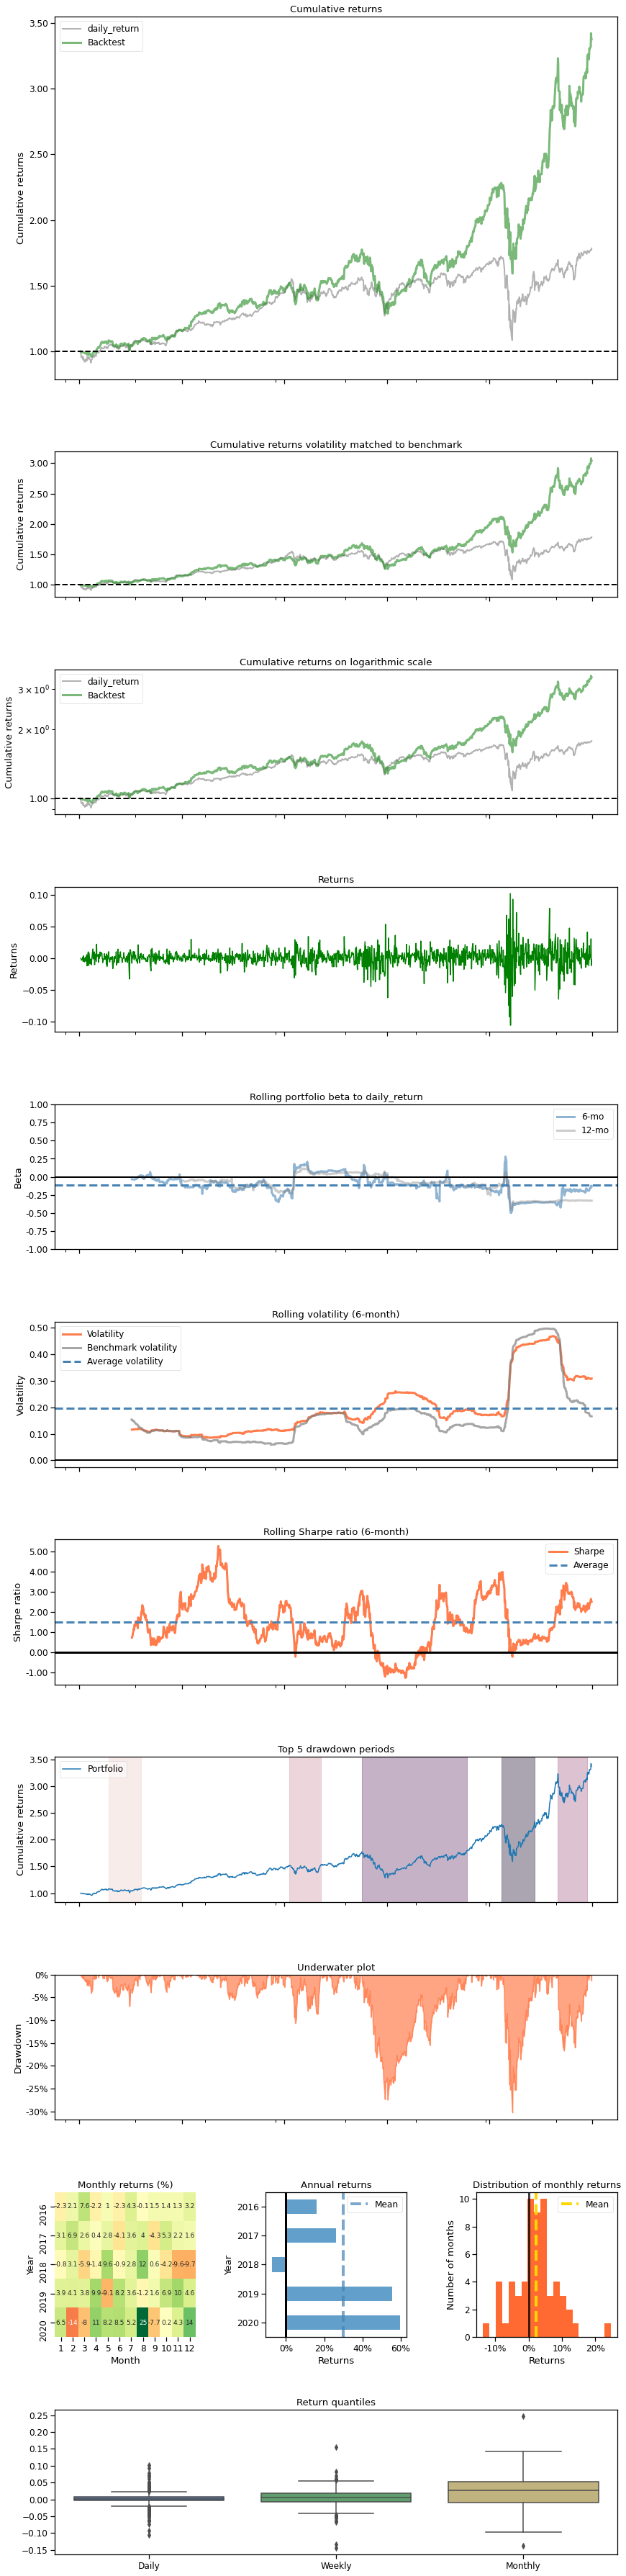

In [62]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2016-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')